<a href="https://colab.research.google.com/github/pradeepelavarasan/GRAD-CAM-Visual-Explanations/blob/master/Pradeep_Elavarasan_EIP3_Phase2_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup & Data Loading

In [0]:
!pip install image-classifiers
!pip install Image
!pip install git+https://github.com/qubvel/classification_models.git
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-8v1ln87f
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-8v1ln87f
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljc7aetb/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
import zipfile
import random
import keras
import numpy as np
from classification_models.resnet import ResNet18, preprocess_input
from classification_models import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import cv2
#from data_science_utils.vision.keras import *


In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#n_classes = 10
# prepare your data

from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/Assignment_5/cifar_10classes.zip') as zf:
  zf.extractall('/content')


In [0]:
train_datagen = ImageDataGenerator(
       #featurewise_center=False,  # set input mean to 0 over the dataset
      # samplewise_center=False,  # set each sample mean to 0
      #  featurewise_std_normalization=False,  # divide inputs by std of the dataset
      #  samplewise_std_normalization=False,  # divide each input by its std
      #  zca_whitening=False,  # apply ZCA whitening
      #  rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
      #  width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
       # height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        zoom_range=[0.5, 1.5], #zoom
      #  vertical_flip=False, # randomly flip images
        rescale= 1./255)  


train_generator = train_datagen.flow_from_directory(
    directory="/content/cifar10/train/",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=250,
    class_mode="categorical",
    shuffle=False,
    seed=1
)

Found 50000 images belonging to 10 classes.


In [0]:
valid_datagen = ImageDataGenerator(
       #featurewise_center=False,  # set input mean to 0 over the dataset
      # samplewise_center=False,  # set each sample mean to 0
      #  featurewise_std_normalization=False,  # divide inputs by std of the dataset
      #  samplewise_std_normalization=False,  # divide each input by its std
      #  zca_whitening=False,  # apply ZCA whitening
      #  rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
      #  width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
       # height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
       # horizontal_flip=True,  # randomly flip images
        #zoom_range=[0.5, 1.5], #zoom
      #  vertical_flip=False, # randomly flip images
        rescale= 1./255)  


valid_generator = valid_datagen.flow_from_directory(
    directory="/content/cifar10/test/",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=1
)

Found 10000 images belonging to 10 classes.


# Model Creation and Refinement

In [0]:
# Refining the model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)

# Freezing existing layers
#for layer in base_model.layers:
#  layer.trainable = False

#Additional Layers to suit ciphar dataset (custom)
additional_layer = keras.layers.SeparableConv2D(filters=10, kernel_size=(3,3),strides=(1,1), padding="same")(base_model.output)
additional_layer_norm = keras.layers.normalization.BatchNormalization(axis=3)(additional_layer)
additional_layer_activation = keras.layers.Activation("relu")(additional_layer_norm)
gap = keras.layers.GlobalAveragePooling2D()(additional_layer_activation)
output = keras.layers.Activation('softmax')(gap)

#Additional Layers to suit ciphar dataset (from reference with dense layer)
#x = keras.layers.GlobalAveragePooling2D()(base_model.output)
#output = keras.layers.Dense(n_classes, activation='softmax')(x)

# Final model
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0720 06:59:38.181235 140111497553792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 06:59:38.238033 140111497553792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 06:59:38.241021 140111497553792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0720 06:59:38.242229 140111497553792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0720 06:59:38.245107 140111

44924928/44920640 [==============================] - 1s 0us/step


W0720 06:59:45.031832 140111497553792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

# Training

In [0]:
model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=20,
                        verbose=1)
#model.fit(X, y)

W0702 16:02:35.651425 139933831931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0702 16:02:35.807746 139933831931776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
200/200 [==============================] - 58s 290ms/step - loss: 1.7889 - acc: 0.4180 - val_loss: 1.5213 - val_acc: 0.5002
Epoch 2/10
200/200 [==============================] - 51s 257ms/step - loss: 1.4443 - acc: 0.5550 - val_loss: 1.2856 - val_acc: 0.5880
Epoch 3/10
200/200 [==============================] - 51s 257ms/step - loss: 1.2721 - acc: 0.6117 - val_loss: 1.1636 - val_acc: 0.6341
Epoch 4/10
200/200 [==============================] - 52s 258ms/step - loss: 1.1619 - acc: 0.6425 - val_loss: 1.0738 - val_acc: 0.6646
Epoch 5/10
200/200 [==============================] - 51s 256ms/step - loss: 1.0742 - acc: 0.6706 - val_loss: 1.0251 - val_acc: 0.6762
Epoch 6/10
200/200 [==============================] - 51s 257ms/step - loss: 1.0100 - acc: 0.6884 - val_loss: 0.9451 - val_acc: 0.7050
Epoch 7/10
200/200 [==============================] - 51s 256ms/step - loss: 0.9514 - acc: 0.7046 - val_loss: 0.8897 - val_acc: 0.7225
Epoch 8/10
200/200 [==============================] - 5

In [0]:
model.save_weights("/content/gdrive/My Drive/Assignment_5/Training_Backup/Assignment5_V1_32x32.hdf5")

In [0]:
model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=50,
                        initial_epoch=10,
                        verbose=1)

Epoch 11/50
200/200 [==============================] - 50s 251ms/step - loss: 0.8143 - acc: 0.7420 - val_loss: 0.7799 - val_acc: 0.7570
Epoch 12/50
200/200 [==============================] - 48s 240ms/step - loss: 0.7855 - acc: 0.7492 - val_loss: 0.7546 - val_acc: 0.7625
Epoch 13/50
200/200 [==============================] - 48s 241ms/step - loss: 0.7695 - acc: 0.7558 - val_loss: 0.7195 - val_acc: 0.7740
Epoch 14/50
200/200 [==============================] - 48s 242ms/step - loss: 0.7485 - acc: 0.7603 - val_loss: 0.7219 - val_acc: 0.7726
Epoch 15/50
200/200 [==============================] - 49s 246ms/step - loss: 0.7326 - acc: 0.7653 - val_loss: 0.7107 - val_acc: 0.7795
Epoch 16/50
200/200 [==============================] - 49s 245ms/step - loss: 0.7191 - acc: 0.7690 - val_loss: 0.6780 - val_acc: 0.7858
Epoch 17/50
200/200 [==============================] - 50s 248ms/step - loss: 0.7016 - acc: 0.7762 - val_loss: 0.6721 - val_acc: 0.7846
Epoch 18/50
200/200 [===========================

In [0]:
model.save_weights("/content/gdrive/My Drive/Assignment_5/Training_Backup/Assignment5_V1_32x32_11-50.hdf5")

In [0]:
model.load_weights("/content/gdrive/My Drive/Assignment_5/Training_Backup/Assignment5_V1_32x32_11-50.hdf5")

In [0]:
model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=100,
                        initial_epoch=50,
                        verbose=1)

Epoch 51/100
200/200 [==============================] - 56s 279ms/step - loss: 0.4225 - acc: 0.8605 - val_loss: 0.5189 - val_acc: 0.8323
Epoch 52/100
200/200 [==============================] - 51s 255ms/step - loss: 0.4155 - acc: 0.8627 - val_loss: 0.5175 - val_acc: 0.8329
Epoch 53/100
200/200 [==============================] - 51s 255ms/step - loss: 0.4086 - acc: 0.8655 - val_loss: 0.5232 - val_acc: 0.8308
Epoch 54/100
200/200 [==============================] - 51s 255ms/step - loss: 0.4122 - acc: 0.8622 - val_loss: 0.5330 - val_acc: 0.8287
Epoch 55/100
200/200 [==============================] - 51s 254ms/step - loss: 0.4033 - acc: 0.8667 - val_loss: 0.5287 - val_acc: 0.8281
Epoch 56/100
200/200 [==============================] - 51s 255ms/step - loss: 0.3936 - acc: 0.8695 - val_loss: 0.5137 - val_acc: 0.8375
Epoch 57/100
200/200 [==============================] - 51s 254ms/step - loss: 0.3864 - acc: 0.8722 - val_loss: 0.5077 - val_acc: 0.8376
Epoch 58/100
200/200 [===================

In [0]:
model.save_weights("/content/gdrive/My Drive/Assignment_5/Training_Backup/Assignment5_V1_32x32_51-100.hdf5")

# Loading Weights

In [0]:
model.load_weights("/content/gdrive/My Drive/Assignment_5/Training_Backup/Assignment5_V1_32x32_51-100.hdf5")

# Gallery of Misclassified Images

In [0]:
actual = valid_generator.classes

In [0]:
valid_generator.reset()
predict = model.predict_generator(valid_generator,verbose=1, steps=valid_generator.n//valid_generator.batch_size)
predicted = np.argmax(predict,axis=1)

10000/10000 [==============================] - 47s 5ms/step


In [0]:
#predict = model.predict_generator(valid_generator,verbose=1, steps=STEP_SIZE_VALID)
#print(predict)
#predicted = np.argmax(predict,axis=1)
#actual = valid_generator.classes

correct_images = []
wrong_images = []

for i in range(predicted.shape[0]):
    if predicted[i] == actual[i]:
        correct_images.append(i)
    elif predicted[i] != actual[i]:
        wrong_images.append(i)
        #print(predicted[i])
        #print(actual[i])

print('Number of correct images: ' + str(len(correct_images)))
print('Number of wrong images: ' + str(len(wrong_images)))

Number of correct images: 8383
Number of wrong images: 1617


In [0]:
correct_names = []
wrong_names = []

for i in correct_images:
    name = valid_generator.filenames[i]
    correct_names.append(name)

for i in wrong_images:
    name = valid_generator.filenames[i]
    wrong_names.append(name)

print('Number of correct images: ' + str(len(correct_names)))
print('Number of wrong images: ' + str(len(wrong_names)))
wrong_names_50 = random.sample(wrong_names, 50)

Number of correct images: 8383
Number of wrong images: 1617


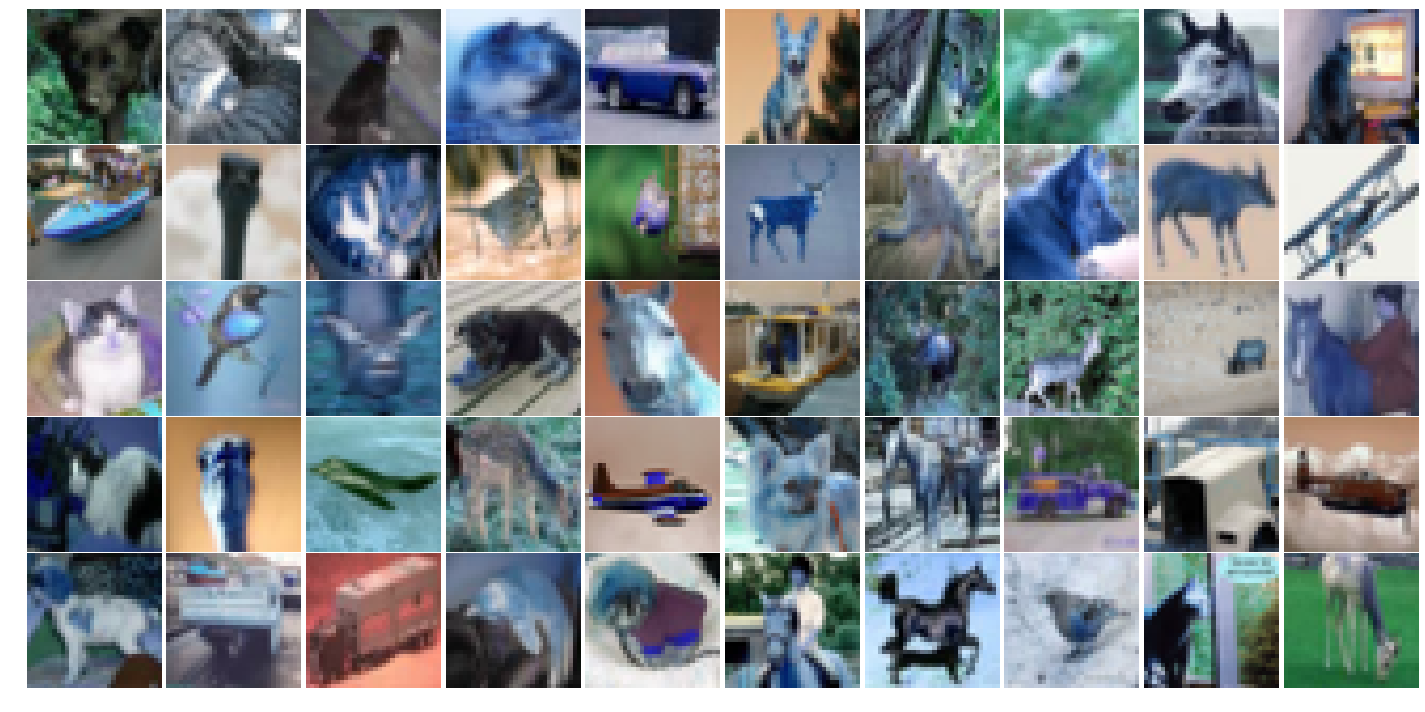

In [0]:
# Display the misclassified Images - random 50

fig=plt.figure(figsize=(25,25))

columns = 10
rows = 10
for i in range(len(wrong_names_50)):
    img = cv2.imread("/content/cifar10/test/" + wrong_names_50[i])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

# Galery of GRAD-CAM Images

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import os

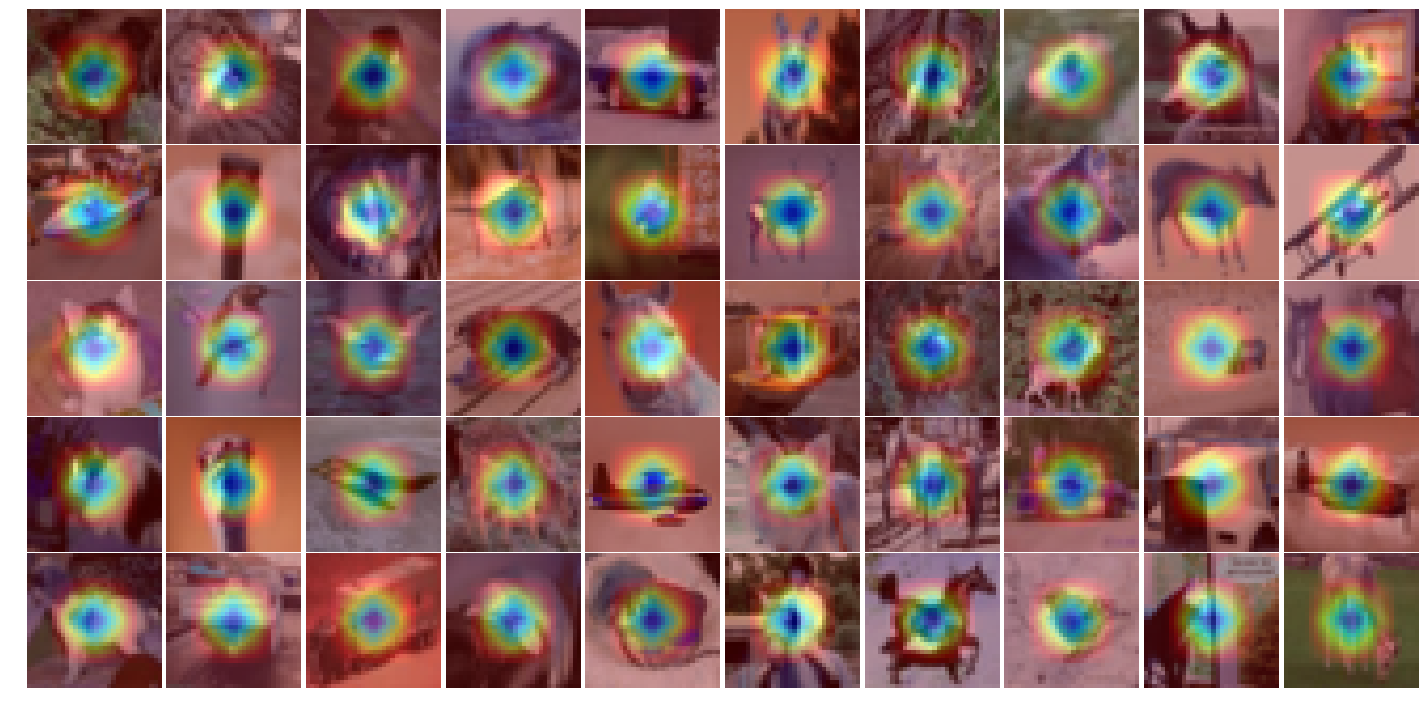

In [0]:
fig2=plt.figure(figsize=(25,25))
columns = 10
rows = 10

for index in range(len(wrong_names_50)):
  img_name = wrong_names_50[index]
  img_path = "/content/cifar10/test/" + img_name
  img = image.load_img(img_path)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("zero_padding2d_17")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  
  #fig2.add_subplot(rows, columns, index+1)
  #plt.imshow(img)
  #plt.axis('off')
  fig2.add_subplot(rows, columns, index+1)
  plt.imshow(superimposed_img)
  plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
  
  #if not os.path.exists("/content/cifar10/gradcam"):
  #      os.mkdir("/content/cifar10/gradcam")
  #cv2.imwrite("/content/cifar10/gradcam/"+str(i)+'.jpg', superimposed_img)
   